In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img
from tensorflow.keras.preprocessing import image
import tensorflow as tf

from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import RMSprop, SGD
from tensorflow.keras.layers import  BatchNormalization, Lambda, Input, Dense, Convolution2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, Dropout, Flatten, Reshape, Activation
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow.keras.backend as k

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from scipy import misc, ndimage

%matplotlib inline

In [2]:
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")
print(tf.__version__)

Default GPU Device:/device:GPU:0
2.1.0


In [3]:
#import Data

train_folder = "C:/Users/Hameez/.conda/envs/gemstone_dataset/Data/Cropped/Train/"
test_folder = "C:/Users/Hameez/.conda/envs/gemstone_dataset/Data/Cropped/Test/"


# img = image.load_img(train_folder+"/Alexandrite/alexandrite_2.jpg")
# # plt.imshow(img)
# # plt.show()
# print(cv2.imread("Data/Train/Alexandrite/alexandrite_24.jpg").shape)

#------------augmentation for train images----------------------------------#
train = ImageDataGenerator(rescale=1./255,
                           shear_range=0.2,
                           zoom_range=0.3,
                           horizontal_flip=True)
#---------------------------------------------------------------------------#

test = ImageDataGenerator(rescale=1./255)


# train_data = train.flow_from_directory(train_folder,
#                                        target_size=(256,256),
#                                        class_mode='categorical')
# test_data = test.flow_from_directory(test_folder,
#                                        target_size=(256,256),
#                                        class_mode='categorical')





In [4]:
def color_net(num_classes, img_rows , img_cols):
    # placeholder for input image
    input_image = Input(shape=(img_rows,img_cols,3))
    # ============================================= TOP BRANCH ===================================================
    # first top convolution layer
    top_conv1 = Convolution2D(filters=48,kernel_size=(11,11),strides=(4,4),
                              input_shape=(224,224,3),activation='relu')(input_image)
    top_conv1 = BatchNormalization()(top_conv1)
    top_conv1 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(top_conv1)

    # second top convolution layer
    # split feature map by half
    top_top_conv2 = Lambda(lambda x : x[:,:,:,:24])(top_conv1)
    top_bot_conv2 = Lambda(lambda x : x[:,:,:,24:])(top_conv1)

    top_top_conv2 = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_top_conv2)
    top_top_conv2 = BatchNormalization()(top_top_conv2)
    top_top_conv2 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(top_top_conv2)

    top_bot_conv2 = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_bot_conv2)
    top_bot_conv2 = BatchNormalization()(top_bot_conv2)
    top_bot_conv2 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(top_bot_conv2)

    # third top convolution layer
    # concat 2 feature map
    top_conv3 = Concatenate()([top_top_conv2,top_bot_conv2])
    top_conv3 = Convolution2D(filters=192,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_conv3)

    # fourth top convolution layer
    # split feature map by half
    top_top_conv4 = Lambda(lambda x : x[:,:,:,:96])(top_conv3)
    top_bot_conv4 = Lambda(lambda x : x[:,:,:,96:])(top_conv3)

    top_top_conv4 = Convolution2D(filters=96,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_top_conv4)
    top_bot_conv4 = Convolution2D(filters=96,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_bot_conv4)

    # fifth top convolution layer
    top_top_conv5 = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_top_conv4)
    top_top_conv5 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(top_top_conv5) 

    top_bot_conv5 = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_bot_conv4)
    top_bot_conv5 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(top_bot_conv5)

    # ============================================= TOP BOTTOM ===================================================
    # first bottom convolution layer
    bottom_conv1 = Convolution2D(filters=48,kernel_size=(11,11),strides=(4,4),
                              input_shape=(227,227,3),activation='relu')(input_image)
    bottom_conv1 = BatchNormalization()(bottom_conv1)
    bottom_conv1 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(bottom_conv1)

    # second bottom convolution layer
    # split feature map by half
    bottom_top_conv2 = Lambda(lambda x : x[:,:,:,:24])(bottom_conv1)
    bottom_bot_conv2 = Lambda(lambda x : x[:,:,:,24:])(bottom_conv1)

    bottom_top_conv2 = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_top_conv2)
    bottom_top_conv2 = BatchNormalization()(bottom_top_conv2)
    bottom_top_conv2 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(bottom_top_conv2)

    bottom_bot_conv2 = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_bot_conv2)
    bottom_bot_conv2 = BatchNormalization()(bottom_bot_conv2)
    bottom_bot_conv2 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(bottom_bot_conv2)

    # third bottom convolution layer
    # concat 2 feature map
    bottom_conv3 = Concatenate()([bottom_top_conv2,bottom_bot_conv2])
    bottom_conv3 = Convolution2D(filters=192,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_conv3)

    # fourth bottom convolution layer
    # split feature map by half
    bottom_top_conv4 = Lambda(lambda x : x[:,:,:,:96])(bottom_conv3)
    bottom_bot_conv4 = Lambda(lambda x : x[:,:,:,96:])(bottom_conv3)

    bottom_top_conv4 = Convolution2D(filters=96,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_top_conv4)
    bottom_bot_conv4 = Convolution2D(filters=96,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_bot_conv4)

    # fifth bottom convolution layer
    bottom_top_conv5 = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_top_conv4)
    bottom_top_conv5 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(bottom_top_conv5) 

    bottom_bot_conv5 = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_bot_conv4)
    bottom_bot_conv5 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(bottom_bot_conv5)

    # ======================================== CONCATENATE TOP AND BOTTOM BRANCH =================================
    conv_output = Concatenate()([top_top_conv5,top_bot_conv5,bottom_top_conv5,bottom_bot_conv5])

    # Flatten
    flatten = Flatten()(conv_output)

    # Fully-connected layer
    FC_1 = Dense(units=1024, activation='relu')(flatten)
    FC_1 = Dropout(0.6)(FC_1)
    FC_2 = Dense(units=1024, activation='relu')(FC_1)
    FC_2 = Dropout(0.6)(FC_2)
    FC_3 = Dense(units=1024, activation='relu')(FC_2)
    FC_3 = Dropout(0.6)(FC_3)
    output = Dense(units=num_classes, activation='softmax')(FC_3)
    
    model = Model(inputs=input_image,outputs=output)
    sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
    # sgd = SGD(lr=0.01, momentum=0.9, decay=0.0005, nesterov=True)
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [5]:
img_rows , img_cols = 227, 227
num_classes = 87
batch_size = 32
nb_epoch = 200

# initialise model
model = color_net(num_classes, img_rows , img_cols)

filepath = 'Saved Models/Good Models/gemstones_cls_weights_v1.7_ep200_SGD.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

training_set = train.flow_from_directory(train_folder,
                                       target_size=(img_rows,img_cols),
                                       class_mode='categorical')
test_set = test.flow_from_directory(test_folder,
                                       target_size=(img_rows,img_cols),
                                       class_mode='categorical')

Found 2857 images belonging to 87 classes.
Found 363 images belonging to 87 classes.


In [6]:
history = model.fit_generator(
    training_set,
    epochs=nb_epoch,
    validation_data=test_set,
    callbacks=callbacks_list)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 90 steps, validate for 12 steps
Epoch 1/200
89/90 [============================>.] - ETA: 0s - loss: 4.6400 - accuracy: 0.0149
Epoch 00001: val_accuracy improved from -inf to 0.00826, saving model to Saved Models/Good Models/gemstones_cls_weights_v1.7_ep200_SGD.hdf5
90/90 [==============================] - 50s 557ms/step - loss: 4.6379 - accuracy: 0.0147 - val_loss: 4.4628 - val_accuracy: 0.0083
Epoch 2/200
89/90 [============================>.] - ETA: 0s - loss: 4.4696 - accuracy: 0.0166
Epoch 00002: val_accuracy improved from 0.00826 to 0.03857, saving model to Saved Models/Good Models/gemstones_cls_weights_v1.7_ep200_SGD.hdf5
90/90 [==============================] - 51s 564ms/step - loss: 4.4697 - accuracy: 0.0168 - val_loss: 4.4509 - val_accuracy: 0.0386
Epoch 3/200
89/90 [============================>.] - ETA: 0s - loss: 4.4338 - accuracy: 0.0219


Epoch 23/200
89/90 [============================>.] - ETA: 0s - loss: 2.8753 - accuracy: 0.1816
Epoch 00023: val_accuracy did not improve from 0.28375
90/90 [==============================] - 45s 498ms/step - loss: 2.8760 - accuracy: 0.1817 - val_loss: 2.4736 - val_accuracy: 0.2590
Epoch 24/200
89/90 [============================>.] - ETA: 0s - loss: 2.8013 - accuracy: 0.2007
Epoch 00024: val_accuracy improved from 0.28375 to 0.29201, saving model to Saved Models/Good Models/gemstones_cls_weights_v1.7_ep200_SGD.hdf5
90/90 [==============================] - 56s 618ms/step - loss: 2.7987 - accuracy: 0.2020 - val_loss: 2.3306 - val_accuracy: 0.2920
Epoch 25/200
89/90 [============================>.] - ETA: 0s - loss: 2.7438 - accuracy: 0.2149
Epoch 00025: val_accuracy did not improve from 0.29201
90/90 [==============================] - 86s 955ms/step - loss: 2.7395 - accuracy: 0.2153 - val_loss: 2.4124 - val_accuracy: 0.2782
Epoch 26/200
89/90 [============================>.] - ETA: 1s -

89/90 [============================>.] - ETA: 0s - loss: 1.9890 - accuracy: 0.3735
Epoch 00049: val_accuracy did not improve from 0.48209
90/90 [==============================] - 60s 662ms/step - loss: 1.9964 - accuracy: 0.3724 - val_loss: 1.7901 - val_accuracy: 0.4766
Epoch 50/200
89/90 [============================>.] - ETA: 0s - loss: 1.9539 - accuracy: 0.3880
Epoch 00050: val_accuracy improved from 0.48209 to 0.49036, saving model to Saved Models/Good Models/gemstones_cls_weights_v1.7_ep200_SGD.hdf5
90/90 [==============================] - 85s 945ms/step - loss: 1.9526 - accuracy: 0.3896 - val_loss: 1.7242 - val_accuracy: 0.4904
Epoch 51/200
89/90 [============================>.] - ETA: 1s - loss: 1.9286 - accuracy: 0.3816
Epoch 00051: val_accuracy did not improve from 0.49036
90/90 [==============================] - 105s 1s/step - loss: 1.9265 - accuracy: 0.3826 - val_loss: 1.7652 - val_accuracy: 0.4793
Epoch 52/200
89/90 [============================>.] - ETA: 1s - loss: 1.8718 -

89/90 [============================>.] - ETA: 0s - loss: 1.4450 - accuracy: 0.5225
Epoch 00075: val_accuracy did not improve from 0.58402
90/90 [==============================] - 75s 832ms/step - loss: 1.4461 - accuracy: 0.5215 - val_loss: 1.5833 - val_accuracy: 0.5344
Epoch 76/200
89/90 [============================>.] - ETA: 0s - loss: 1.4083 - accuracy: 0.5193
Epoch 00076: val_accuracy did not improve from 0.58402
90/90 [==============================] - 89s 992ms/step - loss: 1.4066 - accuracy: 0.5194 - val_loss: 1.5464 - val_accuracy: 0.5372
Epoch 77/200
89/90 [============================>.] - ETA: 1s - loss: 1.3663 - accuracy: 0.5476
Epoch 00077: val_accuracy did not improve from 0.58402
90/90 [==============================] - 167s 2s/step - loss: 1.3684 - accuracy: 0.5481 - val_loss: 1.4671 - val_accuracy: 0.5813
Epoch 78/200
89/90 [============================>.] - ETA: 0s - loss: 1.3894 - accuracy: 0.5373
Epoch 00078: val_accuracy improved from 0.58402 to 0.60331, saving mod

89/90 [============================>.] - ETA: 0s - loss: 1.0398 - accuracy: 0.6538
Epoch 00103: val_accuracy did not improve from 0.61433
90/90 [==============================] - 90s 995ms/step - loss: 1.0397 - accuracy: 0.6531 - val_loss: 1.4641 - val_accuracy: 0.5675
Epoch 104/200
89/90 [============================>.] - ETA: 0s - loss: 1.0030 - accuracy: 0.6598
Epoch 00104: val_accuracy did not improve from 0.61433
90/90 [==============================] - 89s 992ms/step - loss: 1.0042 - accuracy: 0.6605 - val_loss: 1.5108 - val_accuracy: 0.5675
Epoch 105/200
89/90 [============================>.] - ETA: 0s - loss: 0.9913 - accuracy: 0.6669
Epoch 00105: val_accuracy did not improve from 0.61433
90/90 [==============================] - 86s 955ms/step - loss: 0.9899 - accuracy: 0.6675 - val_loss: 1.5993 - val_accuracy: 0.5730
Epoch 106/200
89/90 [============================>.] - ETA: 0s - loss: 0.9704 - accuracy: 0.6641
Epoch 00106: val_accuracy improved from 0.61433 to 0.63085, savin

89/90 [============================>.] - ETA: 1s - loss: 0.6939 - accuracy: 0.7568
Epoch 00131: val_accuracy did not improve from 0.64187
90/90 [==============================] - 143s 2s/step - loss: 0.6909 - accuracy: 0.7578 - val_loss: 1.5743 - val_accuracy: 0.6198
Epoch 132/200
89/90 [============================>.] - ETA: 1s - loss: 0.6875 - accuracy: 0.7550
Epoch 00132: val_accuracy did not improve from 0.64187
90/90 [==============================] - 138s 2s/step - loss: 0.6853 - accuracy: 0.7557 - val_loss: 1.6067 - val_accuracy: 0.6061
Epoch 133/200
89/90 [============================>.] - ETA: 0s - loss: 0.6798 - accuracy: 0.7579
Epoch 00133: val_accuracy did not improve from 0.64187
90/90 [==============================] - 50s 557ms/step - loss: 0.6794 - accuracy: 0.7578 - val_loss: 1.6305 - val_accuracy: 0.6116
Epoch 134/200
89/90 [============================>.] - ETA: 0s - loss: 0.6920 - accuracy: 0.7688
Epoch 00134: val_accuracy did not improve from 0.64187
90/90 [=======

Epoch 160/200
89/90 [============================>.] - ETA: 1s - loss: 0.5501 - accuracy: 0.8032
Epoch 00160: val_accuracy did not improve from 0.64463
90/90 [==============================] - 180s 2s/step - loss: 0.5492 - accuracy: 0.8036 - val_loss: 1.4379 - val_accuracy: 0.6253
Epoch 161/200
89/90 [============================>.] - ETA: 0s - loss: 0.4479 - accuracy: 0.8407
Epoch 00161: val_accuracy did not improve from 0.64463
90/90 [==============================] - 66s 737ms/step - loss: 0.4483 - accuracy: 0.8404 - val_loss: 1.6061 - val_accuracy: 0.6253
Epoch 162/200
89/90 [============================>.] - ETA: 0s - loss: 0.4740 - accuracy: 0.8336
Epoch 00162: val_accuracy did not improve from 0.64463
90/90 [==============================] - 89s 993ms/step - loss: 0.4770 - accuracy: 0.8330 - val_loss: 1.9191 - val_accuracy: 0.5785
Epoch 163/200
89/90 [============================>.] - ETA: 0s - loss: 0.5212 - accuracy: 0.8131
Epoch 00163: val_accuracy did not improve from 0.6446

89/90 [============================>.] - ETA: 0s - loss: 0.3682 - accuracy: 0.8729
Epoch 00188: val_accuracy improved from 0.65840 to 0.66116, saving model to Saved Models/Good Models/gemstones_cls_weights_v1.7_ep200_SGD.hdf5
90/90 [==============================] - 91s 1s/step - loss: 0.3696 - accuracy: 0.8733 - val_loss: 1.6092 - val_accuracy: 0.6612
Epoch 189/200
89/90 [============================>.] - ETA: 0s - loss: 0.3324 - accuracy: 0.8846
Epoch 00189: val_accuracy did not improve from 0.66116
90/90 [==============================] - 89s 993ms/step - loss: 0.3339 - accuracy: 0.8838 - val_loss: 1.9414 - val_accuracy: 0.6446
Epoch 190/200
89/90 [============================>.] - ETA: 0s - loss: 0.3706 - accuracy: 0.8768
Epoch 00190: val_accuracy did not improve from 0.66116
90/90 [==============================] - 89s 994ms/step - loss: 0.3691 - accuracy: 0.8771 - val_loss: 1.9372 - val_accuracy: 0.6419
Epoch 191/200
89/90 [============================>.] - ETA: 0s - loss: 0.3324

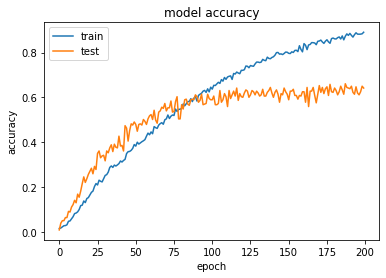

In [7]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

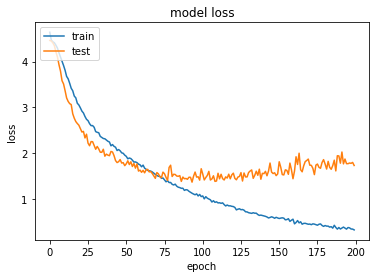

In [8]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:

# model_path ='Saved Models/gs_mcl_v1.5.h5'
# cnn_model.save(model_path)

model = tf.keras.models.load_model(filepath)

In [ ]:
shape = (img_rows, img_cols)
unsean_stone_path = "C:/Users/Hameez/.conda/envs/gemstone_dataset/Data/Unseen/peridot.jpg"
# #img = cv2.imread(os.path.join(unsean_stones_folder)
img = image.load_img(unsean_stone_path, target_size=shape)
img_arr = image.img_to_array(img)
img_arr = np.expand_dims(img_arr, axis=0)
print(os.path.basename(unsean_stone_path))
img

In [ ]:
preds = model.predict(img_arr)
classess = training_set.class_indices
for name in classess:
    if classess[name] == int(preds.argmax()):
        print("Predicts that its a: "+name)
    else:
        "Couldn't find stone name!"

In [ ]:
# x = img_to_array(img)
# x = x.reshape((1,) + x.shape)

# i = 0
# for batch in test_augment.flow(x, batch_size=1,
#                               save_to_dir='Augmented', save_prefix='alexandrite',
#                                save_format='jpeg',):
#     i += 1
#     if i > 20:
#         break